In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import numpy as np

# Define needed classes and functions

### Define the basic blocs for the edge-popup models

In [2]:
class GetMask(autograd.Function):
    @staticmethod
    def forward(self, scores, k):
        out = scores.clone()
        _, idx = scores.flatten().sort()
        j = int((1 - k) * scores.numel())
        
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1
        
        return out
    
    @staticmethod
    def backward(self, g):
        return g, None
    

class PrunedConv(nn.Conv2d):
    def __init__(self, sparsity, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.sparsity = sparsity
        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))
        
        nn.init.kaiming_normal_(self.weight, mode='fan_in', nonlinearity='relu')
        self.weight.requires_grad = False
        
    def forward(self, x):
        mask = GetSubnet.apply(self.scores.abs(), self.sparsity)
        w = self.weight * mask
        x = F.conv2d(
                x, w, self.bias, self.stride, self.padding, self.dilation, self.groups
        )
        
        return x
    
class PrunedLinear(nn.Linear):
    def __init__(self, sparsity, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.sparsity = sparsity
        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))
        
        nn.init.kaiming_normal_(self.weight, mode='fan_in', nonlinearity='relu')
        self.weight.requires_grad = False
        
    def forward(self, x):
        mask = GetSubnet.apply(self.scores.abs(), self.sparsity)

        w = self.weight * mask
        x = F.linear(x, w, self.bias)

        return x
    

### Models for MNIST experiments

In [3]:
class MNIST_Net(nn.Module):
    def __init__(self, k=8):
        super().__init__()
        self.conv1 = nn.Conv2d(1, k, 3, 1, bias=False)
        self.conv2 = nn.Conv2d(k, 2*k, 3, 1, bias=False)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(288*k, 4*k, bias=False)
        self.fc2 = nn.Linear(4*k, 10, bias=False)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        out = F.log_softmax(x, dim=1)
        
        return out
    
    @property
    def num_parameters(self):
        return sum([p.numel() for p in self.parameters() if p.requires_grad])
    

class MNIST_Net_Pruned(nn.Module):
    def __init__(self, sparsity, k=8):
        super().__init__()
        self.sparsity = sparsity
        self.conv1 = PrunedConv(sparsity, 1, k, 3, 1, bias=False)
        self.conv2 = PrunedConv(sparsity, k, 2*k, 3, 1, bias=False)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = PrunedLinear(sparsity, 288*k, 4*k, bias=False)
        self.fc2 = PrunedLinear(sparsity, 4*k, 10, bias=False)
        
    def set_sparsity(self, sparsity):
        self.conv1.sparsity = sparsity
        self.conv2.sparsity = sparsity
        self.fc1.sparsity = sparsity
        self.fc2.sparsity = sparsity
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        out = F.log_softmax(x, dim=1)
        
        return out
    
    @property
    def num_parameters(self):
        return int(self.sparsity * sum([p.numel() for p in self.parameters() if not p.requires_grad]))

### Train and test functions

In [5]:
def train(model, loader, optimizer, criterion, epoch, verbose=False):
    model.train()
    loss = 0
    acc = 0
    for batch_idx, (X, y) in enumerate(loader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        l = criterion(y_pred, y)
        l.backward()
        optimizer.step()
        pred = y_pred.argmax(dim=1, keepdim=True)
        acc += pred.eq(y.view_as(pred)).sum().item()
        loss += l.item()
    
    loss /= len(loader.dataset)
    if verbose:    
        print(f'TR    Loss: {loss:.04f}, Acc: {100.*acc/len(loader.dataset):.02f}')
            
def test(model, loader, criterion, verbose=False):
    model.eval()
    loss = 0
    acc = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += criterion(y_pred, y).item()
            pred = y_pred.argmax(dim=1, keepdim=True)
            acc += pred.eq(y.view_as(pred)).sum().item()
            
    loss /= len(loader.dataset)
    
    if verbose:
        print(f'TS    Loss: {loss:.04f}, Acc: {100.*acc/len(loader.dataset):.02f}')
    
    return loss, 100.*acc/len(loader.dataset)

In [6]:
def get_acc(train_loader, test_loader, mode='optimized', k=2, sparsity=None, seed=42):
    torch.manual_seed(seed)
    
    if mode == 'optimized':
        model = MNIST_Net(k=k).to(device)
        
    else:
        model = MNIST_Net_Pruned(k=k, sparsity=sparsity).to(device)
        
    optimizer = optim.SGD(
        [p for p in model.parameters() if p.requires_grad],
        lr=LR,
        momentum=MOMENTUM,
        weight_decay=WD
    )
    criterion = nn.CrossEntropyLoss().to(device)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
    
    for epoch in range(1, NUM_EPOCHS + 1):
        train(model, train_loader, optimizer, criterion, epoch)
        scheduler.step()
        
    _, train_acc = test(model, train_loader, criterion)   
    _, test_acc = test(model, test_loader, criterion)
    
    
    return train_acc, test_acc

# MNIST experiments

### Setup hyperparameters and load data

In [19]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 128
NUM_EPOCHS = 7
LR = 1e-2
MOMENTUM = 0.9
WD = 5e-4
sparsity_list = [0, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 1]
tsf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST('data', train=True, transform=tsf, download=True)
test_dataset = datasets.MNIST('data', train=False, transform=tsf, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Varying the sparsity parameter

### Optimized weights

In [8]:
train_acc, test_acc = get_acc(train_loader, test_loader, mode='optimized', k=2)
print(f'Train acc: {train_acc:.02f}, test acc: {test_acc:.02f}')

Train acc: 88.99, test acc: 89.17


### Pruned weights

In [20]:
torch.manual_seed(42)
acc_list = []

for sparsity in sparsity_list:
    _, test_acc = get_acc(train_loader, test_loader, mode='pruned', k=2, sparsity=sparsity)
    acc_list.append(test_acc)
    print(f'Sparsity={sparsity}, Test acc={test_acc:.02f}')


Sparsity=0, Test acc=10.28
Sparsity=0.05, Test acc=33.96
Sparsity=0.1, Test acc=55.27
Sparsity=0.3, Test acc=62.90
Sparsity=0.5, Test acc=56.80
Sparsity=0.7, Test acc=47.54
Sparsity=0.9, Test acc=10.02
Sparsity=0.95, Test acc=10.22
Sparsity=1, Test acc=10.72


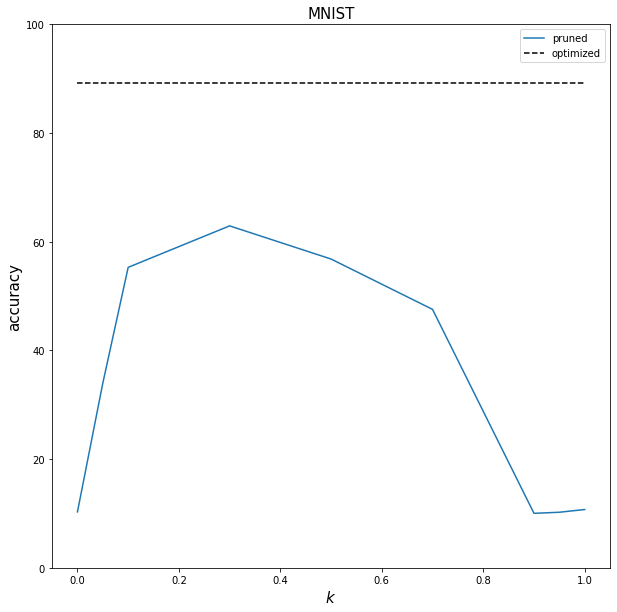

In [26]:
plt.figure(figsize=(10, 10))
plt.plot(sparsity_list, acc_list, label='pruned')
plt.hlines(y=89.17, xmin=0, xmax=1, label='optimized', linestyle='dashed')
plt.legend()
plt.ylim((0, 100))
plt.xlabel('$k$', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.title('MNIST', fontsize=15)
plt.show()

## The effect of overparametrization

In [27]:
k_list = [1, 2, 4, 6, 8, 10, 12]

acc_list = []
acc_list_3 = []
acc_list_5 = []
acc_list_7 = []

for k in k_list:
    # optimized weights
    _, test_acc = get_acc(train_loader, test_loader, mode='optimized', k=k)
    acc_list.append(test_acc)
    
    # sparsity = 0.3
    _, test_acc = get_acc(train_loader, test_loader, mode='pruned', k=k, sparsity=0.3)    
    acc_list_3.append(test_acc)
    
    # sparsity = 0.5
    _, test_acc = get_acc(train_loader, test_loader, mode='pruned', k=k, sparsity=0.5)
    acc_list_5.append(test_acc)
    
    # sparsity = 0.7
    _, test_acc = get_acc(train_loader, test_loader, mode='pruned', k=k, sparsity=0.7)
    acc_list_7.append(test_acc)

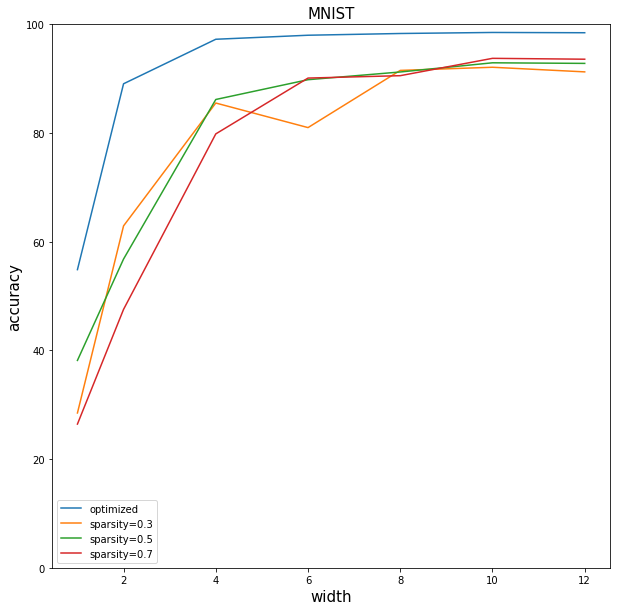

In [28]:
plt.figure(figsize=(10, 10))
plt.plot(k_list, acc_list, label='optimized', linestyle='dashed')
plt.plot(k_list, acc_list_3, label='sparsity=0.3')
plt.plot(k_list, acc_list_5, label='sparsity=0.5')
plt.plot(k_list, acc_list_7, label='sparsity=0.7')
plt.xlabel('width', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.title('MNIST', fontsize=15)
plt.legend()
plt.ylim((0, 100))
plt.show()

## The effect of width

In [29]:
k_list = [10, 11, 12, 13, 14]
sparsity_list = [[1, 0.72, 0.425],
                 [0.835, 0.6, 0.36],
                 [0.7, 0.5, 0.35],
                 [0.595, 0.425, 0.25],
                 [0.515, 0.365, 0.22]]
acc_list_3 = []
acc_list_5 = []
acc_list_7 = []

for k, s_list in zip(k_list, sparsity_list):
    s7, s5, s3 = s_list
    
    # sparsity = 0.3
    _, test_acc = get_acc(train_loader, test_loader, mode='pruned', k=k, sparsity=s3)
    acc_list_3.append(test_acc)
    
    # sparsity = 0.5
    _, test_acc = get_acc(train_loader, test_loader, mode='pruned', k=k, sparsity=s5)
    acc_list_5.append(test_acc)
    
    # sparsity = 0.7
    _, test_acc = get_acc(train_loader, test_loader, mode='pruned', k=k, sparsity=s7)
    acc_list_7.append(test_acc)

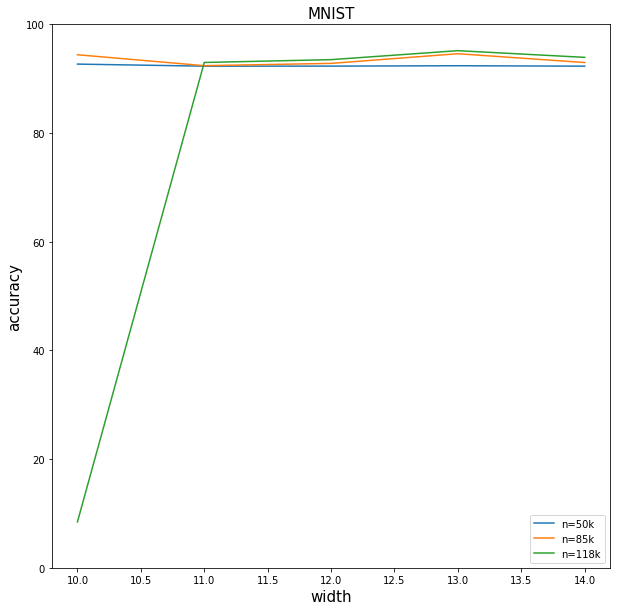

In [30]:
plt.figure(figsize=(10, 10))
plt.plot(k_list, acc_list_3, label='n=50k')
plt.plot(k_list, acc_list_5, label='n=85k')
plt.plot(k_list, acc_list_7, label='n=118k')
plt.title('MNIST', fontsize=15)
plt.xlabel('width', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.legend()
plt.ylim((0, 100))
plt.show()